In [1]:
"""
========================================================================
Variational with merge and delete proposals for DP mixtures of Gaussians
========================================================================

How delete moves can be more effective than merges.

In this example, we show how merge moves alone may not be enough 
to reliably escape local optima. Instead, we show that more flexible
delete moves can escape from situations where merges alone fail.
"""
import bnpy
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

FIG_SIZE = (3, 3)
plt.rcParams['figure.figsize'] = FIG_SIZE

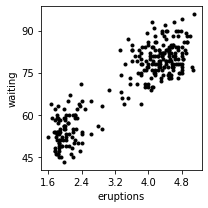

In [2]:
###############################################################################
#
# Load dataset from file


dataset_path = os.path.join(bnpy.DATASET_PATH, 'faithful')
dataset = bnpy.data.XData.read_csv(
    os.path.join(dataset_path, 'faithful.csv'))

###############################################################################
#
# Make a simple plot of the raw data

plt.plot(dataset.X[:, 0], dataset.X[:, 1], 'k.')
plt.xlabel(dataset.column_names[0])
plt.ylabel(dataset.column_names[1])
plt.tight_layout()
data_ax_h = plt.gca()
plt.show()

###############################################################################
# Setup: Determine specific settings of the proposals
# ---------------------------------------------------

merge_kwargs = dict(
    m_startLap=10,
    m_pair_ranking_procedure='total_size',
    m_pair_ranking_direction='descending',
    )

delete_kwargs = dict(
    d_startLap=20,
    d_nRefineSteps=50,
    )

In [3]:
###############################################################################
#
# Setup: Helper function to display the learned clusters
# ------------------------------------------------------

def show_clusters_over_time(
        task_output_path=None,
        query_laps=[0, 1, 2, 10, 20, None],
        nrows=2):
    '''
    '''
    ncols = int(np.ceil(len(query_laps) // float(nrows)))
    fig_handle, ax_handle_list = plt.subplots(
        figsize=(FIG_SIZE[0] * ncols, FIG_SIZE[1] * nrows),
        nrows=nrows, ncols=ncols, sharex=True, sharey=True)
    for plot_id, lap_val in enumerate(query_laps):
        cur_model, lap_val = bnpy.load_model_at_lap(task_output_path, lap_val)
        cur_ax_handle = ax_handle_list.flatten()[plot_id]
        bnpy.viz.PlotComps.plotCompsFromHModel(
            cur_model, dataset=dataset, ax_handle=cur_ax_handle)
        cur_ax_handle.set_title("lap: %d" % lap_val)
        cur_ax_handle.set_xlabel(dataset.column_names[0])
        cur_ax_handle.set_ylabel(dataset.column_names[1])
        cur_ax_handle.set_xlim(data_ax_h.get_xlim())
        cur_ax_handle.set_ylim(data_ax_h.get_ylim())
    plt.tight_layout()
    plt.show()

Dataset Summary:
X Data
  total size: 272 units
  batch size: 272 units
  num. batches: 1
Allocation Model:  DP mixture with K=0. Concentration gamma0= 5.00
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 4 
  beta = [ 10  10] 
  Expectations
  E[  mean[k]] = 
  [ 0  0]
  E[ covar[k]] = 
  [[5. 0.]
   [0. 5.]]
Initialization:
  initname = randexamplesbydist
  K = 25 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/faithful/trymoves-K=25-gamma=5.0-lik=DiagGauss-ECovMat=5.0*eye-moves=none/1
    1.000/1000 after      0 sec. |    143.7 MiB | K   25 | loss  3.062238769e+00 |  
    2.000/1000 after      0 sec. |    143.7 MiB | K   25 | loss  3.029485836e+00 | Ndiff    3.204 
    3.000/1000 after      0 sec. |    143.7 MiB | K   25 | loss  2.988929671e+00 | Ndiff    3.849 
    4.0

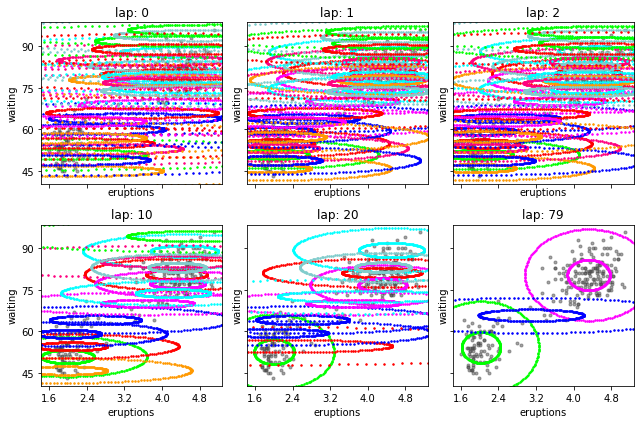

In [4]:
###############################################################################
#
# *DiagGauss* observation model, without moves
# --------------------------------------------
#
# Start with too many clusters (K=25)

gamma = 5.0
sF = 5.0
K = 25

diag1_trained_model, diag1_info_dict = bnpy.run(
    dataset, 'DPMixtureModel', 'DiagGauss', 'memoVB',
    output_path=('/tmp/faithful/' + 
        'trymoves-K=%d-gamma=%s-lik=DiagGauss-ECovMat=%s*eye-moves=none/' % (
            K, gamma, sF)),
    nLap=1000, nTask=1, nBatch=1, convergeThr=0.0001,
    gamma0=gamma, sF=sF, ECovMat='eye',
    K=K, initname='randexamplesbydist',
    )
show_clusters_over_time(diag1_info_dict['task_output_path'])

Dataset Summary:
X Data
  total size: 272 units
  batch size: 272 units
  num. batches: 1
Allocation Model:  DP mixture with K=0. Concentration gamma0= 5.00
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 4 
  beta = [ 10  10] 
  Expectations
  E[  mean[k]] = 
  [ 0  0]
  E[ covar[k]] = 
  [[5. 0.]
   [0. 5.]]
Initialization:
  initname = randexamplesbydist
  K = 25 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/faithful/trymoves-K=25-gamma=5.0-lik=DiagGauss-ECovMat=5.0*eye-moves=merge,delete,shuffle/1
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
DELETE @ lap 1.00: Disabled. Cannot delete before first complete lap, because SS that represents whole dataset is required.
    1.000/100 after      0 sec. |    158.8 MiB

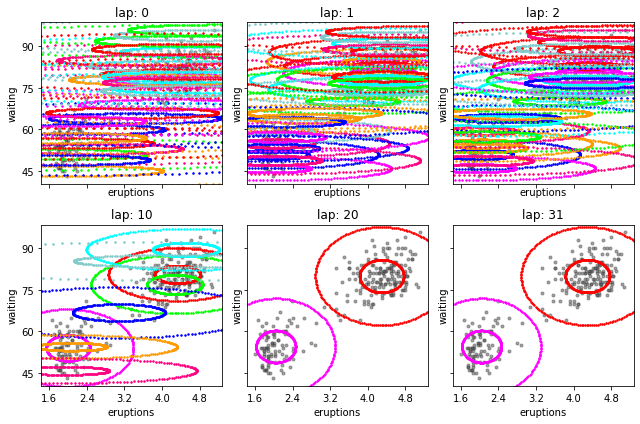

In [5]:
###############################################################################
#
# *DiagGauss* observation model
# --------------------------------------
#
# Start with too many clusters (K=25)
# Use merges and deletes to reduce to a better set.

gamma = 5.0
sF = 5.0
K = 25

diag_trained_model, diag_info_dict = bnpy.run(
    dataset, 'DPMixtureModel', 'DiagGauss', 'memoVB',
    output_path=('/tmp/faithful/' + 
        'trymoves-K=%d-gamma=%s-lik=DiagGauss-ECovMat=%s*eye-moves=merge,delete,shuffle/' % (
            K, gamma, sF)),
    nLap=100, nTask=1, nBatch=1,
    gamma0=gamma, sF=sF, ECovMat='eye',
    K=K, initname='randexamplesbydist',
    moves='merge,delete,shuffle',
    **dict(list(delete_kwargs.items()) + list(merge_kwargs.items())))

show_clusters_over_time(diag_info_dict['task_output_path'])

Dataset Summary:
X Data
  total size: 272 units
  batch size: 272 units
  num. batches: 1
Allocation Model:  DP mixture with K=0. Concentration gamma0= 5.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on mean and covar of each cluster
  E[  mean[k] ] = 
   [0. 0.] 
  E[ covar[k] ] = 
  [[5. 0.]
   [0. 5.]]
Initialization:
  initname = randexamplesbydist
  K = 25 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/faithful/trymoves-K=25-gamma=5.0-lik-Gauss-ECovMat=5.0*eye-moves=merge,delete,shuffle/1
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
DELETE @ lap 1.00: Disabled. Cannot delete before first complete lap, because SS that represents whole dataset is required.
    1.000/100 after      0 sec. |    167.6 MiB | K   25 | loss  2.959097158e+00 |  
MERGE @ lap 2.00: Disabled. Waiti

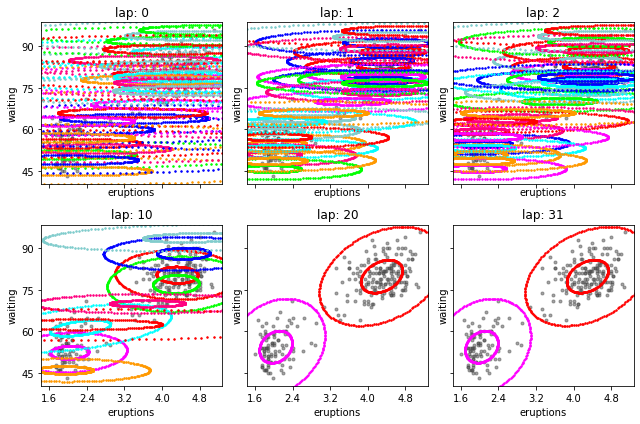

In [6]:
###############################################################################
#
# *Gauss* observation model
# -------------------------
#
# Start with too many clusters (K=25)
# Use merges and deletes to reduce to a better set.

full_trained_model, full_info_dict = bnpy.run(
    dataset, 'DPMixtureModel', 'Gauss', 'memoVB',
    output_path=('/tmp/faithful/' + 
        'trymoves-K=%d-gamma=%s-lik-Gauss-ECovMat=%s*eye-moves=merge,delete,shuffle/' % (
            K, gamma, sF)),
    nLap=100, nTask=1, nBatch=1,
    gamma0=gamma, sF=sF, ECovMat='eye',
    K=K, initname='randexamplesbydist',
    moves='merge,delete,shuffle',
    **dict(list(delete_kwargs.items()) + list(merge_kwargs.items())))

show_clusters_over_time(full_info_dict['task_output_path'])

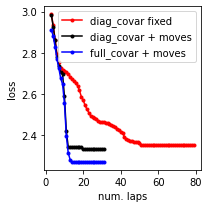

In [7]:
###############################################################################
# 
# Loss function trace plot
# ------------------------
#
plt.figure()
plt.plot(
    diag1_info_dict['lap_history'][2:],
    diag1_info_dict['loss_history'][2:], 'r.-',
    label='diag_covar fixed')
plt.plot(
    diag_info_dict['lap_history'][2:],
    diag_info_dict['loss_history'][2:], 'k.-',
    label='diag_covar + moves')
plt.plot(
    full_info_dict['lap_history'][2:],
    full_info_dict['loss_history'][2:], 'b.-',
    label='full_covar + moves')
plt.legend(loc='upper right')
plt.xlabel('num. laps')
plt.ylabel('loss')
plt.tight_layout()
plt.show()